In [1]:
import numpy as np
import csv
import glob
import os.path
from os import path
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import talib

In [3]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%d-%b-%Y'
        self.column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [4]:
luv = FileInstrument('../../../Developer/Data/prices/NYSE/LUV.csv')

In [5]:
d = np.diff(luv['close'], prepend=luv['close'][0])

In [6]:
luv.attach_feature(d, 'back_returns')

In [7]:
luv['back_returns']

array([ 0.  , -0.29, -0.04, ...,  0.16,  0.08, -0.07])

In [8]:
def run_monte_single(asset, idx, samples=1000, simulations=1000):
    returns = asset['forward_returns'][idx]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [18]:
mc = run_monte_single(luv, luv['close'] > talib.EMA(luv['close'], timeperiod=100), samples=50000)

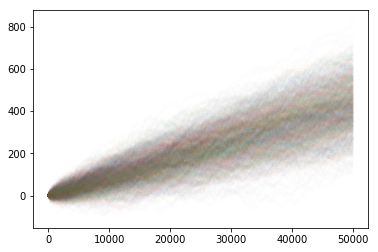

In [35]:
plt.plot(mc.T, alpha=0.01)

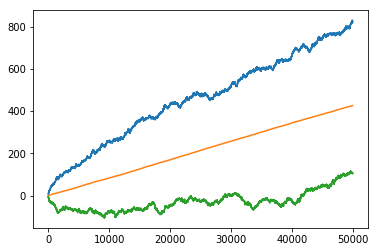

In [33]:
plt.plot(np.max(mc, axis=0))
plt.plot(np.mean(mc, axis=0))
plt.plot(np.min(mc, axis=0))

In [25]:
aapl = FileInstrument('../../../Developer/Data/prices/NASDAQ/AAPL.csv')

In [200]:
d = np.diff(aapl['close'], prepend=aapl['close'][0])
aapl.attach_feature(d, 'back_returns')

In [274]:
mc = run_monte_single(aapl, aapl['back_returns'] > talib.EMA(aapl['back_returns'], timeperiod=100))

In [275]:
vanilla = run_monte_single(aapl, np.random.choice([True, False], size=len(aapl[:,0]), p=[1, 0]))

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  4.,  2., 14., 11.,
        20., 17., 19., 25., 30., 30., 31., 42., 45., 50., 50., 47., 61.,
        53., 53., 42., 44., 46., 55., 34., 30., 20., 24., 19., 17., 11.,
        15., 10.,  5.,  5.,  3.,  5.,  1.,  0.,  2.,  0.,  1.]),
 array([-59.4128  , -53.771324, -48.129848, -42.488372, -36.846896,
        -31.20542 , -25.563944, -19.922468, -14.280992,  -8.639516,
         -2.99804 ,   2.643436,   8.284912,  13.926388,  19.567864,
         25.20934 ,  30.850816,  36.492292,  42.133768,  47.775244,
         53.41672 ,  59.058196,  64.699672,  70.341148,  75.982624,
         81.6241  ,  87.265576,  92.907052,  98.548528, 104.190004,
        109.83148 , 115.472956, 121.114432, 126.755908, 132.397384,
        138.03886 , 143.680336, 149.321812, 154.963288, 160.604764,
        166.24624 , 171.887716, 177.529192, 183.170668, 188.812144,
        194.45362 , 200.095096, 205.736572, 211.378048, 217.019524,
        222.661   ]),
 <a list of 50

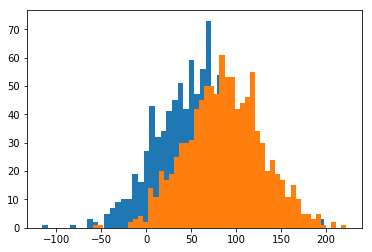

In [276]:
plt.hist(vanilla[:,-1], bins=50)
plt.hist(mc[:,-1], bins=50)

In [277]:
strat = aapl['close'] > talib.EMA(aapl['close'], timeperiod=100)

In [278]:
performance = strat.astype(int) * aapl['forward_returns']

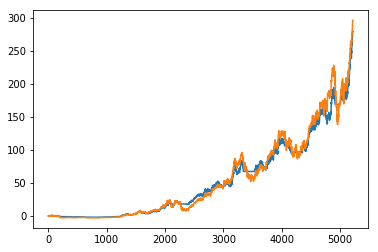

In [279]:
plt.plot(np.cumsum(performance))
plt.plot(np.cumsum(aapl['forward_returns']))

In [229]:
time_in_market = np.sum(strat.astype(int)) / len(strat)

In [230]:
strat_perf = np.cumsum(performance)
buy_hold_perf = np.cumsum(aapl['forward_returns'])

In [231]:
strat_v_bh = strat_perf[-1] / buy_hold_perf[-1]

In [232]:
print(f'Time in the market: \t\t{time_in_market*100:.2f}%')
print(f'Performance against BH: \t{strat_v_bh*100:.2f}%')
print(f'Volatility efficiency: \t\t{(strat_v_bh / time_in_market)*100:.2f}%')

Time in the market: 		68.75%
Performance against BH: 	94.38%
Volatility efficiency: 		137.28%


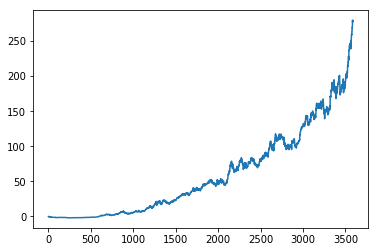

In [233]:
plt.plot(np.cumsum(aapl['forward_returns'][strat]))

In [240]:
from statsmodels.stats.weightstats import ttest_ind

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [246]:
ttest_ind(mc[:,-1], vanilla[:,-1])

(11.916499481165387, 1.118334764648676e-31, 1998.0)

In [261]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.997):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [262]:
mean_confidence_interval(mc[:,-1])

(79.91429529999996, 76.12847634234573, 83.70011425765419)

In [267]:
mean_confidence_interval(vanilla[:,-1])

(57.8981869, 53.91336159189923, 61.883012208100766)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f86df1b7d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f86df1c8400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f86df1b7be0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f86df1c8a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f86df1c8dd8>,
 'means': []}

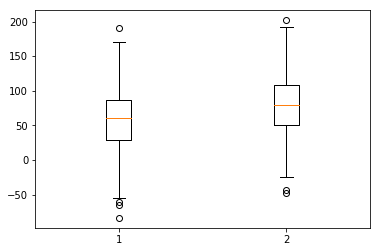

In [271]:
plt.boxplot((vanilla[:,-1], mc[:,-1]))

In [273]:
scipy.stats.ttest_ind(mc[:,-1], vanilla[:,-1])

Ttest_indResult(statistic=11.916499481165374, pvalue=1.1183347646488526e-31)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 7.000e+00,
        9.000e+00, 8.000e+00, 7.000e+00, 1.800e+01, 2.600e+01, 4.000e+01,
        4.900e+01, 7.700e+01, 1.340e+02, 3.060e+02, 8.660e+02, 2.544e+03,
        4.900e+02, 2.550e+02, 1.280e+02, 7.000e+01, 5.400e+01, 3.300e+01,
        1.800e+01, 1.800e+01, 7.000e+00, 8.000e+00, 1.400e+01, 4.000e+00,
        6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00]),
 array([-15.73  , -15.1912, -14.6524, -14.1136, -13.5748, -13.036 ,
        -12.4972, -11.9584, -11.4196, -10.8808, -10.342 ,  -9.8032,
         -9.2644,  -8.7256,  -8.1868,  -7.648 ,  -7.1092,  -6.5704,
         -6.0316,  -5.4928,  -4.954 ,  -4.4152,  -3.8764,  -3.3376,
         -2.7988,  -2.26  ,  -1.7212,  -1.1824,  -0.6436,  -0.1048,
          0.434 ,   0.9728,   1.5116

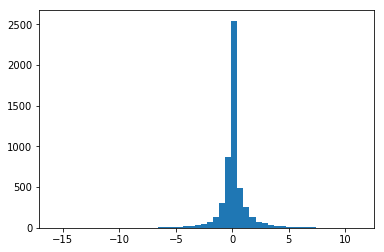

In [38]:
plt.hist(aapl['forward_returns'], bins=50)